# 債券ポートフォリオの作成

In [82]:
import sys
import os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.optimize import minimize
import yfinance as yf

from dividends_reinvestment_return import dividends_reinvestment_return

In [2]:
# データの読み込み
path = '../../../../data/raw/investment_trust.parquet'
df = pl.read_parquet(path)
df.head()

isin_code,investment_trust_association_japan_code,investment_name,date,nav,net_assets_million
str,str,str,date,i64,f64
null,"""0431U169""","""ifree_emerging_markets_bond_in…",2016-09-08,10053,1.005303
null,"""0431U169""","""ifree_emerging_markets_bond_in…",2016-09-09,10089,1.008859
null,"""0431U169""","""ifree_emerging_markets_bond_in…",2016-09-12,9994,1.936575
null,"""0431U169""","""ifree_emerging_markets_bond_in…",2016-09-13,9893,2.309483
null,"""0431U169""","""ifree_emerging_markets_bond_in…",2016-09-14,9912,2.98453


In [37]:
# 銘柄名，コードの確認
df[['investment_trust_association_japan_code', 'investment_name']].unique()

investment_trust_association_japan_code,investment_name
str,str
"""0331418A""","""emaxis_slim_all_world_equity_a…"
"""0331C177""","""emaxis_slim_emerging_markets_e…"
"""3312175""","""emaxis_slim_balance_8_asset_eq…"
"""0431U169""","""ifree_emerging_markets_bond_in…"
"""89311216""","""sbi_v_us_equity_index_fund"""
"""3312184""","""emaxis_slim_all_country_3_regi…"
"""3311187""","""emaxis_slim_us_equity_sp500"""
"""0331A172""","""emaxis_slim_developed_governme…"
"""8931117C""","""sbi_emerging_markets_equity_in…"


## 個別銘柄の分析

### eMAXIS Slim 先進国債 インデックス

return: 6.48%
volatility: 6.13%
sharp ratio: 1.06


Text(0, 0.5, '累積リターン (%)')

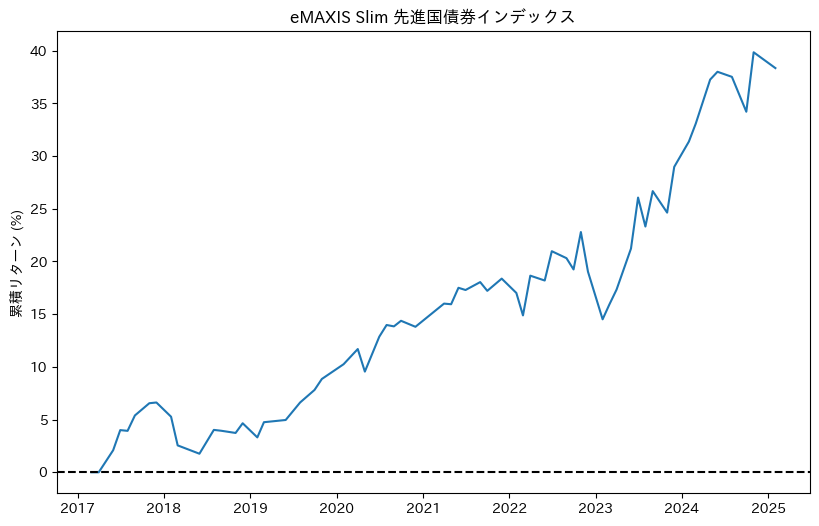

In [4]:
dev_bond = df.filter(pl.col('investment_trust_association_japan_code') == '0331A172')
dev_bond.head()

end_of_month = dev_bond.select(
    pl.col('date').dt.month_end().unique()
)
dev_bond = dev_bond.filter(
    pl.col('date').is_in(end_of_month)
)
dev_bond = dev_bond.with_columns(
    pl.col('nav').log().alias('nav_log'),
    pl.col('nav').log().diff().alias('nav_log_diff')
)
dev_bond = dev_bond.with_columns(
    (pl.col('nav_log') - dev_bond['nav_log'][0]).alias('log_return'),
)
dev_bond = dev_bond.with_columns(
    ((pl.col('log_return').exp() - 1) * 100).alias('return')
)

years = len(dev_bond) / 12
v_first = dev_bond['nav'][0]
v_last = dev_bond['nav'][-1]
dev_bond_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'return: {dev_bond_cagr:.2%}')

dev_vol = np.std(dev_bond['nav_log_diff'].drop_nulls().to_numpy()) * np.sqrt(12)
print(f'volatility: {dev_vol:.2%}')

rf = 0
sharpe_ratio = (dev_bond_cagr - rf) / dev_vol
print(f'sharp ratio: {sharpe_ratio:.2f}')

fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(dev_bond['date'], dev_bond['return'])
ax.axhline(0, ls='--', color='black')
ax.set_title('eMAXIS Slim 先進国債券インデックス')
ax.set_ylabel('累積リターン (%)')

### 中国債券 ICBC FTSE 中国国債インデックス

In [13]:
ticker = yf.Tickers(['CYC.SI', 'SGDJPY=X'])
historical_data = ticker.history(period='max', interval='1d')

cn_bond = pl.DataFrame({
    'date': historical_data.index,
    'Close': historical_data['Close']['CYC.SI'] * historical_data['Close']['SGDJPY=X'],
    'Dividends': historical_data['Dividends']['CYC.SI'] * historical_data['Close']['SGDJPY=X'],
}).drop_nulls().with_columns(
    pl.col('date').cast(pl.Date),
)
end_of_month = cn_bond.select(
    pl.col('date').dt.month_end().unique()
)
cn_bond = cn_bond.filter(
    pl.col('date').is_in(end_of_month)
)
cn_bond = dividends_reinvestment_return(cn_bond, initial_shares=10000)
cn_bond.head()

years = len(cn_bond) / 12
v_first = cn_bond['Value'][0]
v_last = cn_bond['Value'][-1]
cn_bond_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'return: {cn_bond_cagr:.2%}')

log_diff = cn_bond['Close'].log().diff().drop_nulls().to_numpy()
cn_vol = np.std(log_diff) * np.sqrt(12)
print(f'volatility: {cn_vol:.2%}')

rf = 0
sharpe_ratio = (cn_bond_cagr - rf) /cn_vol
print(f'sharp ratio: {sharpe_ratio:.2f}')

[*********************100%***********************]  2 of 2 completed


return: 31.94%
volatility: 13.55%
sharp ratio: 2.36


Text(0.5, 1.0, '中国国債')

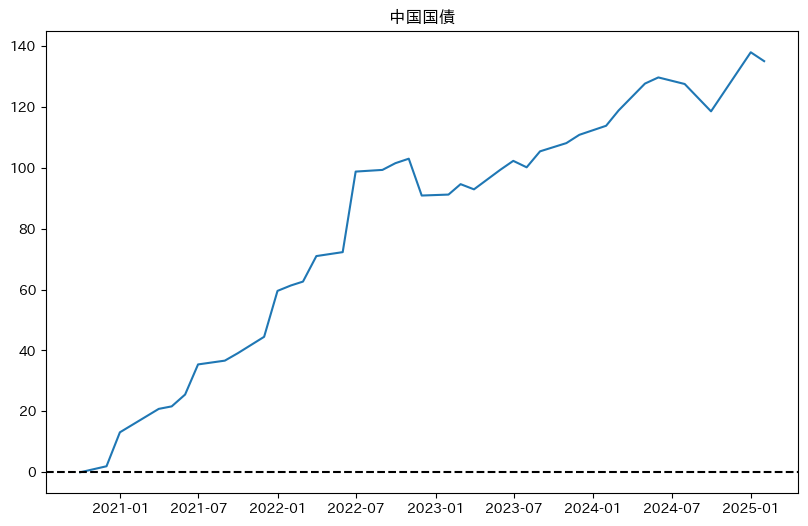

In [14]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(cn_bond['date'], cn_bond['Return'])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_title('中国国債')

### 上場豪債

In [15]:
ticker = yf.Ticker('2844.T')
historical_data = ticker.history(period='max', interval='1mo')
au_bond = pl.DataFrame({
    'date': historical_data.index,
    'Close': historical_data['Close'],
    'Dividends': historical_data['Dividends'],
}).with_columns(
    pl.col('date').cast(pl.Date),
)

au_bond = dividends_reinvestment_return(au_bond, initial_shares=10000)

au_bond.head()

years = len(au_bond) / 12
v_first = au_bond['Value'][0]
v_last = au_bond['Value'][-1]
au_bond_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'年率リターン: {au_bond_cagr:.2%}')

log_diff = au_bond['Close'].log().diff()
au_vol = np.std(log_diff.drop_nulls().to_numpy()) * np.sqrt(12)
print(f'ボラティリティ: {au_vol:.2%}')

rf = 0.0
sharpe_ratio = (au_bond_cagr - rf) /au_vol
print(f'Sharpe ratio: {sharpe_ratio:.2f}')

年率リターン: 6.88%
ボラティリティ: 10.33%
Sharpe ratio: 0.67


Text(0.5, 1.0, '上場豪債')

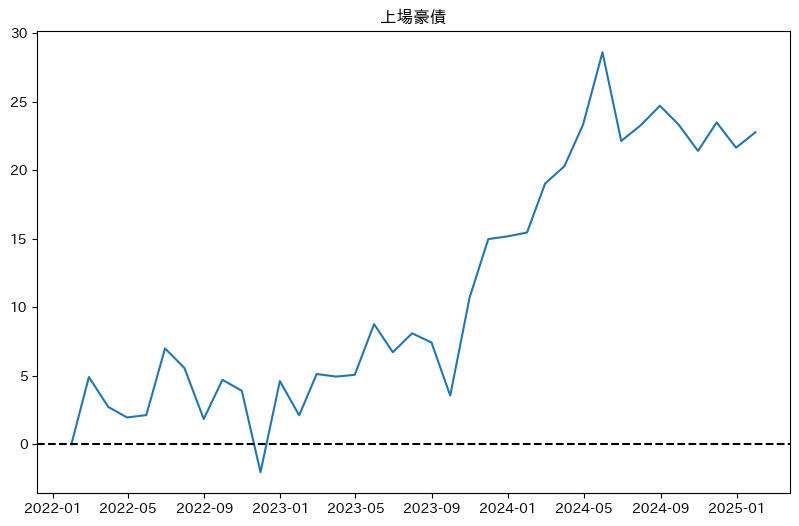

In [16]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(au_bond['date'], au_bond['Return'])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_title('上場豪債')

### ABFシンガポール債券

In [17]:
ticker = yf.Tickers(['A35.SI', 'SGDJPY=X'])
historical_data = ticker.history(period='max', interval='1d')

sg_bond = pl.DataFrame({
    'date': historical_data.index,
    'Close': historical_data['Close']['A35.SI'] * historical_data['Close']['SGDJPY=X'],
    'Dividends': historical_data['Dividends']['A35.SI'] * historical_data['Close']['SGDJPY=X'],
}).drop_nulls().with_columns(
    pl.col('date').cast(pl.Date),
)
end_of_month = sg_bond.select(
    pl.col('date').dt.month_end().unique()
)
sg_bond = sg_bond.filter(
    pl.col('date').is_in(end_of_month)
)
sg_bond = dividends_reinvestment_return(sg_bond, initial_shares=10000)
sg_bond.head()

years = len(sg_bond) / 12
v_first = sg_bond['Value'][0]
v_last = sg_bond['Value'][-1]
sg_bond_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'return: {sg_bond_cagr:.2%}')

log_diff = sg_bond['Close'].log().diff().drop_nulls().to_numpy()
sg_vol = np.std(log_diff) * np.sqrt(12)
print(f'volatility: {sg_vol:.2%}')

rf = 0
sharpe_ratio = (sg_bond_cagr - rf) /sg_vol
print(f'sharp ratio: {sharpe_ratio:.2f}')

[*********************100%***********************]  2 of 2 completed

return: 6.02%
volatility: 9.68%
sharp ratio: 0.62


Text(0.5, 1.0, 'ABFシンガポール債')

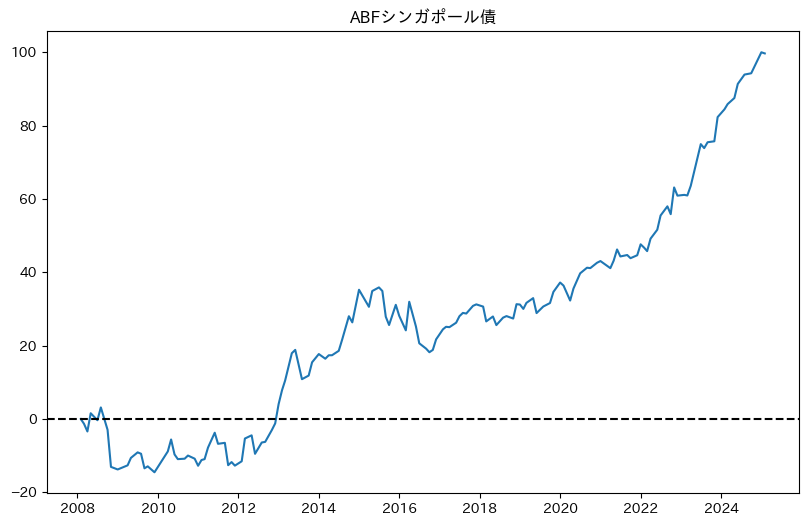

In [18]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(sg_bond['date'], sg_bond['Return'])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_title('ABFシンガポール債')

### iFree 新興国債券インデックス

return: 8.67%
volatility: 11.42%
sharp ratio: 0.76


Text(0, 0.5, '累積リターン (%)')

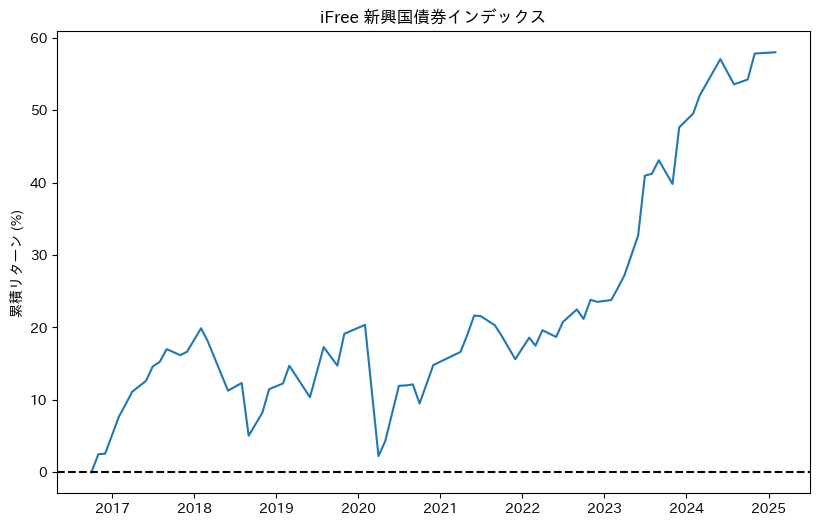

In [19]:
em_bond = df.filter(pl.col('investment_trust_association_japan_code') == '0431U169')
em_bond.head()

end_of_month = em_bond.select(
    pl.col('date').dt.month_end().unique()
)
em_bond = em_bond.filter(
    pl.col('date').is_in(end_of_month)
)
em_bond = em_bond.with_columns(
    pl.col('nav').log().alias('nav_log'),
    pl.col('nav').log().diff().alias('nav_log_diff')
)
em_bond = em_bond.with_columns(
    (pl.col('nav_log') - em_bond['nav_log'][0]).alias('log_return'),
)
em_bond = em_bond.with_columns(
    ((pl.col('log_return').exp() - 1) * 100).alias('return')
)

years = len(em_bond) / 12
v_first = em_bond['nav'][0]
v_last = em_bond['nav'][-1]
em_bond_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'return: {em_bond_cagr:.2%}')

lem_vol = np.std(em_bond['nav_log_diff'].drop_nulls().to_numpy()) * np.sqrt(12)
print(f'volatility: {lem_vol:.2%}')

rf = 0
sharpe_ratio = (em_bond_cagr - rf) / lem_vol
print(f'sharp ratio: {sharpe_ratio:.2f}')

fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(em_bond['date'], em_bond['return'])
ax.axhline(0, ls='--', color='black')
ax.set_title('iFree 新興国債券インデックス')
ax.set_ylabel('累積リターン (%)')

### NF新興国債券

年率リターン: 10.92%
ボラティリティ: 11.42%
Sharpe ratio: 0.96


Text(0.5, 1.0, '新興国債')

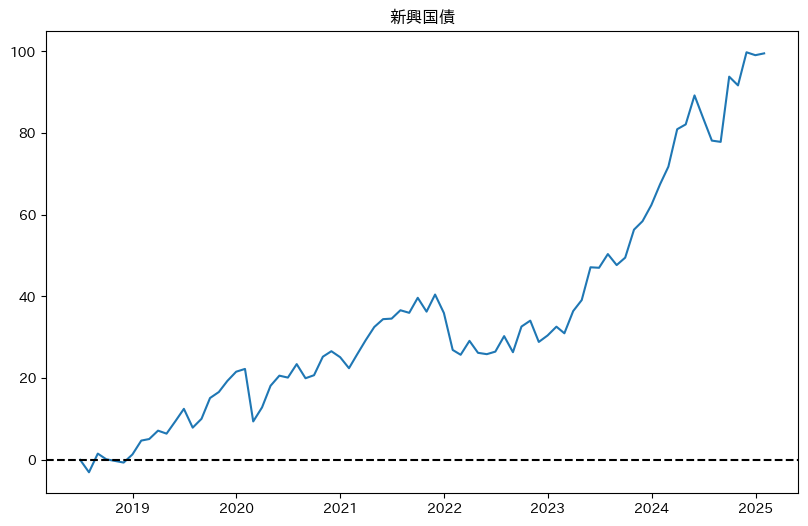

In [54]:
ticker = yf.Ticker('2519.T')
historical_data = ticker.history(period='max', interval='1mo')
em_bond_doll = pl.DataFrame({
    'date': historical_data.index,
    'Close': historical_data['Close'],
    'Dividends': historical_data['Dividends'],
}).with_columns(
    pl.col('date').cast(pl.Date),
)

em_bond_doll = dividends_reinvestment_return(em_bond_doll, initial_shares=10000)

years = len(em_bond_doll) / 12
v_first = em_bond_doll['Value'][0]
v_last = em_bond_doll['Value'][-1]
em_bond_doll_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'年率リターン: {em_bond_doll_cagr:.2%}')

log_diff = em_bond_doll['Close'].log().diff()
dem_vol = np.std(log_diff.drop_nulls().to_numpy()) * np.sqrt(12)
print(f'ボラティリティ: {lem_vol:.2%}')

rf = 0.0
sharpe_ratio = (em_bond_doll_cagr - rf) / lem_vol
print(f'Sharpe ratio: {sharpe_ratio:.2f}')

fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(em_bond_doll['date'], em_bond_doll['Return'])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_title('新興国債')


## バックテスト

### 最初に比率を考える

In [126]:
# 地域比率の辞書
dev_region_dict = {
    'america': 47.38,
    'asia_pacific': 13.77,
    'emea': 37.75
}
em_l_region_dict = {
    'america': 27.4,
    'asia_pacific': 39.5,
    'emea': 30.7
}
em_d_region_dict = {
    'america': 44.74,
    'asia_pacific': 5.87,
    'emea': 46.69
}

cn = 100
au = 100
sg = 100

# wgt = [0.5, 0.1, 0.1, 0.1, 0.1, 0.1]
# risk parity
# wgt = [0.35, 0.15, 0.1, 0.1, 0.15, 0.15]
# equal weight
wgt = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]
print(f'{np.sum(wgt):.2f}')

wgt_america = dev_region_dict['america'] * wgt[0] + em_l_region_dict['america'] * wgt[4] + em_d_region_dict['america'] * wgt[5]
wgt_asia_pacific = dev_region_dict['asia_pacific'] * wgt[0] + cn * wgt[1] + au * wgt[2] + sg * wgt[3] + em_l_region_dict['asia_pacific'] * wgt[4] + em_d_region_dict['asia_pacific'] * wgt[5]
wgt_emea = dev_region_dict['emea'] * wgt[0] + em_l_region_dict['emea'] * wgt[4] + em_d_region_dict['emea'] * wgt[5]
stdv = np.std([wgt_america, wgt_asia_pacific, wgt_emea])

print(f'アメリカ: {wgt_america:.2f}')
print(f'アジア太平洋: {wgt_asia_pacific:.2f}')
print(f'EMEA: {wgt_emea:.2f}')
print(f'標準偏差: {stdv:.2f}')
print(f'偏差２乗和: {(stdv**2)*3:.2f}')
dev_us = 46.6
print(f'アメリカ合衆国: {dev_us*wgt[0]:.2f}')
dev_cn = 11.4
print(f'中国: {dev_cn*wgt[0] + cn*wgt[1]:.2f}')

1.00
アメリカ: 19.92
アジア太平洋: 59.86
EMEA: 19.19
標準偏差: 19.00
偏差２乗和: 1083.08
アメリカ合衆国: 7.77
中国: 18.57


### 計算用のデータフレームを作成

In [ ]:
weights = np.array([0.5, 0.05, 0.1, 0.1, 0.15, 0.1]).T
print(f'Sum: {np.sum(weights):.2f}')

# return
return_list = np.array([dev_bond_cagr, cn_bond_cagr, au_bond_cagr, sg_bond_cagr, em_bond_cagr, em_bond_doll_cagr])

# volatility
dev_bond_df = pl.DataFrame({
    'date': dev_bond['date'],
    'dev_bond_value': dev_bond['nav'].log()
})
cn_bond_df = pl.DataFrame({
    'date': cn_bond['date'],
    'cn_bond_value': cn_bond['Value'].log()
})
au_bond_df = pl.DataFrame({
    'date': au_bond['date'],
    'au_bond_value': au_bond['Value'].log()
})
sg_bond_df = pl.DataFrame({
    'date': sg_bond['date'],
    'sg_bond_value': sg_bond['Value'].log()
})
em_bond_df = pl.DataFrame({
    'date': em_bond['date'],
    'em_bond_value': em_bond['nav'].log()
})
em_bond_doll_df = pl.DataFrame({
    'date': em_bond_doll['date'],
    'em_bond_doll_value': em_bond_doll['Value'].log()
})
bond_df = sg_bond_df.join(
        dev_bond_df, on='date', how='left'
    ).join(
        au_bond_df, on='date', how='left'
    ).join(
        em_bond_df, on='date', how='left'
    ).join(
        em_bond_doll_df, on='date', how='left'
    ).join(
        cn_bond_df, on='date', how='left'
    ).drop_nulls()

tmp = np.array([
    bond_df['dev_bond_value'].diff().drop_nulls(),
    bond_df['cn_bond_value'].diff().drop_nulls(),
    bond_df['au_bond_value'].diff().drop_nulls(),
    bond_df['sg_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_doll_value'].diff().drop_nulls()
])
Sigma = np.cov(tmp)
sigma_p = np.sqrt

Sum: 1.00


### 先進国債，豪債，シンガポール債券

In [168]:
weights = np.array([0.1, 0.1, 0.8]).T

# return
return_list = np.array([au_bond_cagr, sg_bond_cagr, dev_bond_cagr])
return_p = weights @ return_list
print(f'portfolio return: {return_p:.2%}')

sg_bond_df = pl.DataFrame({
    'date': sg_bond['date'],
    'sg_bond_value': sg_bond['Value'].log()
})
dev_bond_df = pl.DataFrame({
    'date': dev_bond['date'],
    'dev_bond_value': dev_bond['nav'].log()
})
au_bond_df = pl.DataFrame({
    'date': au_bond['date'],
    'au_bond_value': au_bond['Value'].log()
})
bond_df = sg_bond_df.join(
        dev_bond_df, on='date', how='left'
    ).join(
        au_bond_df, on='date', how='left'
    ).drop_nulls()

tmp = np.array([
    bond_df['au_bond_value'].diff().drop_nulls(),
    bond_df['sg_bond_value'].diff().drop_nulls(),
    bond_df['dev_bond_value'].diff().drop_nulls()
])
Sigma = np.cov(tmp)
sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'portfolio volatility: {sigma_p:.2%}')

rf = 0
sharpe_ratio = (return_p - rf) / sigma_p
print(f'sharp ratio: {sharpe_ratio:.2f}')

portfolio return: 6.49%
portfolio volatility: 7.11%
sharp ratio: 0.91


Text(0.5, 1.0, '債券ポートフォリオ')

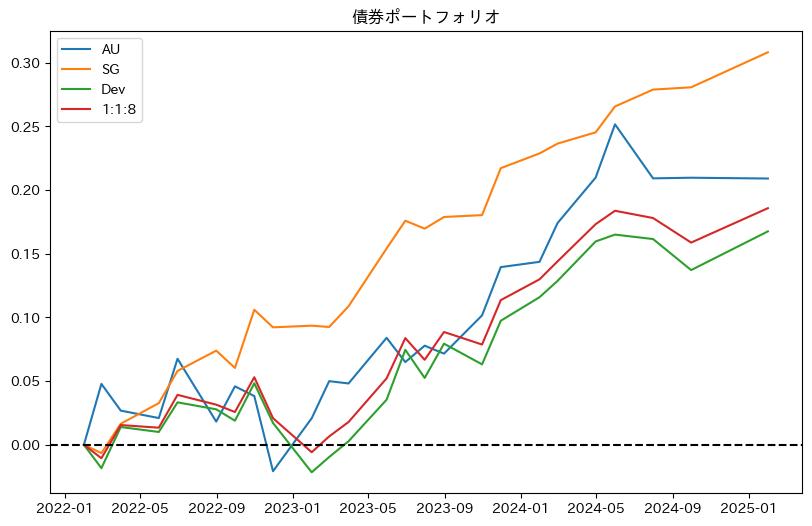

In [189]:
au = bond_df['au_bond_value'] - bond_df['au_bond_value'][0]
sg = bond_df['sg_bond_value'] - bond_df['sg_bond_value'][0]
dev = bond_df['dev_bond_value'] - bond_df['dev_bond_value'][0]

pf = 0.1 * au + 0.1 * sg + 0.8 * dev

fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(bond_df['date'], au, label='AU')
ax.plot(bond_df['date'], sg, label='SG')
ax.plot(bond_df['date'], dev, label='Dev')
ax.plot(bond_df['date'], pf, label='1:1:8')
ax.axhline(0, color='k', ls='--')
ax.legend()
ax.set_title('債券ポートフォリオ')

### 豪，シンガポール，先進国，現地通貨建て新興国

In [200]:
weights = np.array([0.1, 0.1, 0.55, 0.25]).T

# return
return_list = np.array([au_bond_cagr, sg_bond_cagr, dev_bond_cagr, em_bond_cagr])
return_p = weights @ return_list
print(f'portfolio return: {return_p:.2%}')

sg_bond_df = pl.DataFrame({
    'date': sg_bond['date'],
    'sg_bond_value': sg_bond['Value'].log()
})
dev_bond_df = pl.DataFrame({
    'date': dev_bond['date'],
    'dev_bond_value': dev_bond['nav'].log()
})
au_bond_df = pl.DataFrame({
    'date': au_bond['date'],
    'au_bond_value': au_bond['Value'].log()
})
em_bond_df = pl.DataFrame({
    'date': em_bond['date'],
    'em_bond_value': em_bond['nav'].log()
})
bond_df = sg_bond_df.join(
        dev_bond_df, on='date', how='left'
    ).join(
        au_bond_df, on='date', how='left'
    ).join(
        em_bond_df, on='date', how='left'
    ).drop_nulls()

tmp = np.array([
    bond_df['au_bond_value'].diff().drop_nulls(),
    bond_df['sg_bond_value'].diff().drop_nulls(),
    bond_df['dev_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_value'].diff().drop_nulls()
])
Sigma = np.cov(tmp)
sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'portfolio volatility: {sigma_p:.2%}')

rf = 0
sharpe_ratio = (return_p - rf) / sigma_p
print(f'sharp ratio: {sharpe_ratio:.2f}')

portfolio return: 7.04%
portfolio volatility: 6.55%
sharp ratio: 1.07


### 豪，シンガポール，現地通貨建て新興国，ドル建て新興国

In [23]:
weights = np.array([0.1, 0.1, 0.50, 0.15, 0.15]).T

# return
return_list = np.array([au_bond_cagr, sg_bond_cagr, dev_bond_cagr, em_bond_cagr, em_bond_doll_cagr])
return_p = weights @ return_list
print(f'portfolio return: {return_p:.2%}')

sg_bond_df = pl.DataFrame({
    'date': sg_bond['date'],
    'sg_bond_value': sg_bond['Value'].log()
})
dev_bond_df = pl.DataFrame({
    'date': dev_bond['date'],
    'dev_bond_value': dev_bond['nav'].log()
})
au_bond_df = pl.DataFrame({
    'date': au_bond['date'],
    'au_bond_value': au_bond['Value'].log()
})
em_bond_df = pl.DataFrame({
    'date': em_bond['date'],
    'em_bond_value': em_bond['nav'].log()
})
em_bond_doll_df = pl.DataFrame({
    'date': em_bond_doll['date'],
    'em_bond_doll_value': em_bond_doll['Value'].log()
})
bond_df = sg_bond_df.join(
        dev_bond_df, on='date', how='left'
    ).join(
        au_bond_df, on='date', how='left'
    ).join(
        em_bond_df, on='date', how='left'
    ).join(
        em_bond_doll_df, on='date', how='left'
    ).drop_nulls()

tmp = np.array([
    bond_df['au_bond_value'].diff().drop_nulls(),
    bond_df['sg_bond_value'].diff().drop_nulls(),
    bond_df['dev_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_doll_value'].diff().drop_nulls()
])
Sigma = np.cov(tmp)
sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'portfolio volatility: {sigma_p:.2%}')

rf = 0
sharpe_ratio = (return_p - rf) / sigma_p
print(f'sharp ratio: {sharpe_ratio:.2f}')

portfolio return: 7.47%
portfolio volatility: 6.22%
sharp ratio: 1.20


### Dev, CN, AU, SG, EM(L), EM(D)

In [55]:
weights = np.array([0.5, 0.05, 0.1, 0.1, 0.15, 0.1]).T
print(f'Sum: {np.sum(weights):.2f}')

return_p = weights @ return_list
print(f'portfolio return: {return_p:.2%}')

(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'portfolio volatility: {sigma_p:.2%}')

rf = 0
sharpe_ratio = (return_p - rf) / sigma_p
print(f'sharp ratio: {sharpe_ratio:.2f}')

Sum: 1.00
portfolio return: 8.52%
portfolio volatility: 6.35%
sharp ratio: 1.34


### リスクパリティ

In [124]:
sum_inv_vol = 1 / dev_vol + 1 / cn_vol + 1 / au_vol + 1 / sg_vol + 1 / + 1 / lem_vol + 1 / dem_vol
weights = np.array([
    (1 / dev_vol) / sum_inv_vol,
    (1 / cn_vol) / sum_inv_vol,
    (1 / au_vol) / sum_inv_vol,
    (1 / sg_vol) / sum_inv_vol,
    (1 / lem_vol) / sum_inv_vol,
    (1 / dem_vol) / sum_inv_vol
])

# weights = np.array([0.35, 0.15, 0.1, 0.1, 0.15, 0.15]).T
print(f'Sum: {np.sum(weights):.2f}')

# return
return_p = weights @ return_list
print(f'portfolio return: {return_p:.2%}')

sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'portfolio volatility: {sigma_p:.2%}')

rf = 0
sharpe_ratio = (return_p - rf) / sigma_p
print(f'sharp ratio: {sharpe_ratio:.2f}')

Sum: 1.00
portfolio return: 10.48%
portfolio volatility: 6.14%
sharp ratio: 1.71


### 均等ポートフォリオ

In [73]:
weights = np.array([1/6]*6).T

# return
return_p = weights @ return_list
print(f'portfolio return: {return_p:.2%}')

sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'portfolio volatility: {sigma_p:.2%}')

rf = 0
sharpe_ratio = (return_p - rf) / sigma_p
print(f'sharp ratio: {sharpe_ratio:.2f}')

portfolio return: 11.82%
portfolio volatility: 6.30%
sharp ratio: 1.88


## 図示

### 効率的フロンティア

weights: 2.7619717846307408e-17


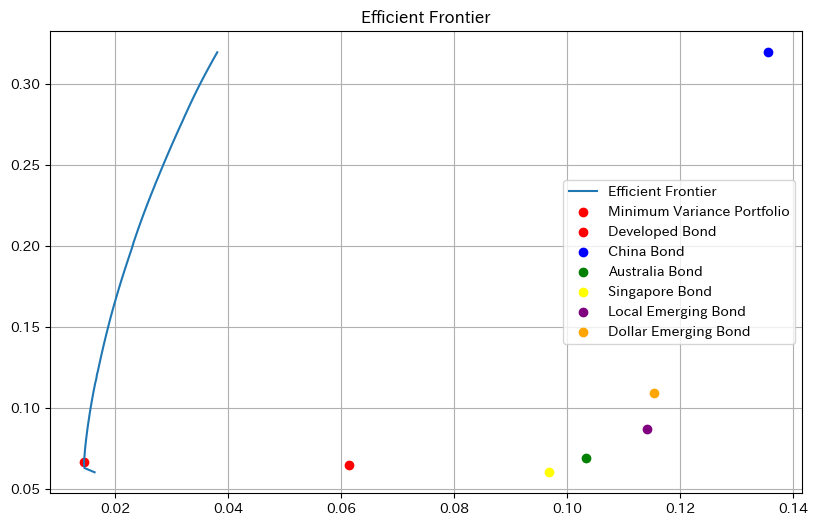

In [ ]:
def portfolio_return(weights, returns):
    return np.sum(weights * returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

num_assets = len(return_list)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for asset in range(num_assets))

def min_variance_portfolio(returns, cov_matrix):
    args = (cov_matrix,)
    result = minimize(
        portfolio_volatility, num_assets * [1. / num_assets,], args=args,
        method='SLSQP', bounds=bounds, constraints=constraints
    )
    return result

min_var_result = min_variance_portfolio(return_list, Sigma)
min_var_weights = min_var_result.x
min_var_return = portfolio_return(min_var_weights, return_list)
min_var_volatility = portfolio_volatility(min_var_weights, Sigma)

def efficient_frontier(returns, cov_matrix, num_points=100):
    results = np.zeros((3, num_points))
    target_returns = np.linspace(min(returns), max(returns), num_points)
    
    for i, target in enumerate(target_returns):
        constraints = (
            {'type': 'eq', 'fun': lambda weights: portfolio_return(weights, returns) - target},
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
        )
        result = minimize(
            portfolio_volatility, num_assets * [1. / num_assets,], args=(cov_matrix,),
            method='SLSQP', bounds=bounds, constraints=constraints
        )
        results[0, i] = portfolio_volatility(result.x, cov_matrix)
        results[1, i] = target
        results[2, i] = result.fun
    
    return results

ef_results = efficient_frontier(return_list, Sigma)

fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(ef_results[0], ef_results[1], label='Efficient Frontier')
ax.scatter(min_var_volatility, min_var_return, color='red', label='Minimum Variance Portfolio')
ax.scatter(dev_vol, dev_bond_cagr, label='Developed Bond', color='red')
ax.scatter(cn_vol, cn_bond_cagr, label='China Bond', color='blue')
ax.scatter(au_vol, au_bond_cagr, label='Australia Bond', color='green')
ax.scatter(sg_vol, sg_bond_cagr, label='Singapore Bond', color='yellow')
ax.scatter(lem_vol, em_bond_cagr, label='Local Emerging Bond', color='purple')
ax.scatter(dem_vol, em_bond_doll_cagr, label='Dollar Emerging Bond', color='orange')
ax.set_title('Efficient Frontier')
ax.grid()
ax.legend()

In [123]:
print(f'Dev: {min_var_weights[0]:.2%}')
print(f'CN: {min_var_weights[1]:.2%}')
print(f'AU: {min_var_weights[2]:.2%}')
print(f'SG: {min_var_weights[3]:.2%}')
print(f'LEM: {min_var_weights[4]:.2%}')
print(f'DEM: {min_var_weights[5]:.2%}')


Dev: 0.00%
CN: 0.00%
AU: 17.80%
SG: 68.01%
LEM: 10.31%
DEM: 3.89%


In [122]:
def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    p_return = portfolio_return(weights, returns)
    p_volatility = portfolio_volatility(weights, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

risk_free_rate = 0.02
sharpe_args = (return_list, Sigma, risk_free_rate)
max_sharpe_result = minimize(neg_sharpe_ratio, num_assets * [1. / num_assets,], args=sharpe_args,
                             method='SLSQP', bounds=bounds, constraints=constraints)

max_sharpe_weights = max_sharpe_result.x
max_sharpe_return = portfolio_return(max_sharpe_weights, return_list)
max_sharpe_volatility = portfolio_volatility(max_sharpe_weights, Sigma)

print(f'Dev: {max_sharpe_weights[0]:.2%}')
print(f'CN: {max_sharpe_weights[1]:.2%}')
print(f'AU: {max_sharpe_weights[2]:.2%}')
print(f'SG: {max_sharpe_weights[3]:.2%}')
print(f'LEM: {max_sharpe_weights[4]:.2%}')
print(f'DEM: {max_sharpe_weights[5]:.2%}')


Dev: 0.00%
CN: 71.59%
AU: 0.00%
SG: 0.00%
LEM: 12.48%
DEM: 15.94%


Text(0.5, 1.0, '債券ポートフォリオ')

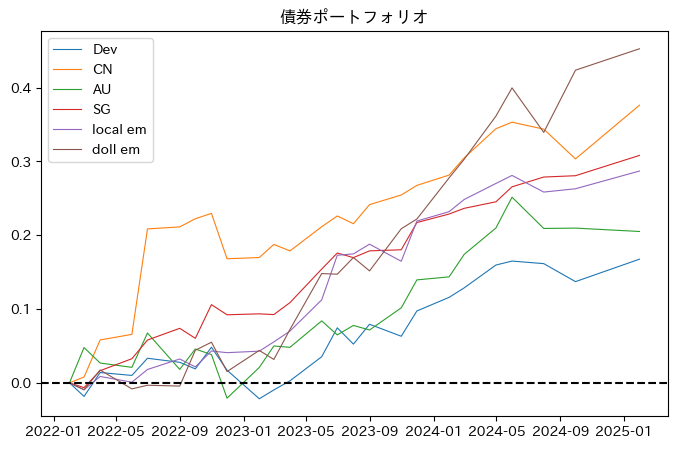

In [80]:
dev = bond_df['dev_bond_value'] - bond_df['dev_bond_value'][0]
cn = bond_df['cn_bond_value'] - bond_df['cn_bond_value'][0]
au = bond_df['au_bond_value'] - bond_df['au_bond_value'][0]
sg = bond_df['sg_bond_value'] - bond_df['sg_bond_value'][0]
lem = bond_df['em_bond_value'] - bond_df['em_bond_value'][0]
dem = bond_df['em_bond_doll_value'] - bond_df['em_bond_doll_value'][0]

fig, ax = plt.subplots(figsize=(1.618*5, 5))
ax.plot(bond_df['date'], dev, label='Dev', lw=0.8)
ax.plot(bond_df['date'], cn, label='CN', lw=0.8)
ax.plot(bond_df['date'], au, label='AU', lw=0.8)
ax.plot(bond_df['date'], sg, label='SG', lw=0.8)
ax.plot(bond_df['date'], lem, label='local em', lw=0.8)
ax.plot(bond_df['date'], dem, label='doll em', lw=0.8)
ax.axhline(0, color='k', ls='--')
ax.legend()
ax.set_title('債券ポートフォリオ')

Text(0.5, 1.0, '債券ポートフォリオ')

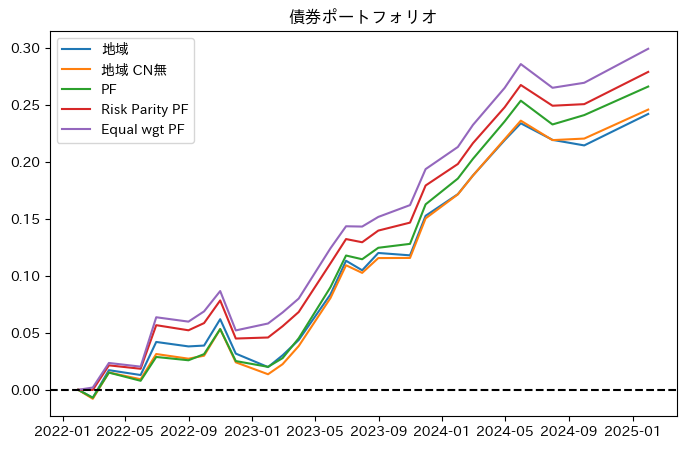

In [81]:
pf_region = 0.5 * dev + 0.05 * cn + 0.1 * au + 0.1 * sg + 0.15 * lem + 0.1 * dem
pf_region_no_cn = 0.5 * dev + 0.1 * au + 0.1 * sg + 0.15 * lem + 0.15 * dem
pf = 0.4 * dev + 0.1 * au + 0.1 * sg + 0.2 * lem + 0.2 * dem
pf_rp = 0.27 * dev + 0.12 * cn + 0.16 * au + 0.17 * sg + 0.14 * lem + 0.14 * dem
pf_eqwgt = (dev + cn + au + sg + lem + dem) / 6

fig, ax = plt.subplots(figsize=(1.618*5, 5))
ax.plot(bond_df['date'], pf_region, label='地域')
ax.plot(bond_df['date'], pf_region_no_cn, label='地域 CN無')
ax.plot(bond_df['date'], pf, label='PF')
ax.plot(bond_df['date'], pf_rp, label='Risk Parity PF')
ax.plot(bond_df['date'], pf_eqwgt, label='Equal wgt PF')
# ax.plot(bond_df['date'], dev_only_pf, label='PF EM無', lw=1)
# ax.plot(bond_df['date'], lem_pf, label='PF 現値通貨建EM有 $建EM無')
# ax.plot(bond_df['date'], dem_pf, label='PF $建EM有')
# ax.plot(bond_df['date'], rp_pf, label='Risk Parity PF')
# ax.plot(bond_df['date'], eq_pf, label='Equal Weight PF')
ax.axhline(0, color='k', ls='--')
ax.legend()
ax.set_title('債券ポートフォリオ')